In [1]:
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
import os
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from collections import Counter
import joblib
import matplotlib.pyplot as plt
from io import BytesIO
import IPython.display as display
import ipywidgets as widgets
#the following are to do with this interactive notebook code

%matplotlib inline
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook


In [2]:
age_model1_path = 'Age_Model_1.h5'
age_model2_path = 'Age_Model_2.h5'
age_model3_path = 'Age_Model_3.h5'

In [3]:
age_model1=load_model(age_model1_path)
age_model2=load_model(age_model2_path)
age_model3=load_model(age_model3_path)


In [4]:
gender_model_path_resnet = 'Gender_Model_Resnet.h5'
gender_model_path_inception = 'Gender_Model_Inception.h5'
gender_model_path_cnn = 'Gender_Model_Cnn.h5'

In [5]:
gender_model_resnet = load_model(gender_model_path_resnet)
gender_model_inception = load_model(gender_model_path_inception)
gender_model_cnn = load_model(gender_model_path_cnn)

In [6]:
age_ranges = ['1-2', '3-6','6-9', '10-15', '15-20', '21-27', '28-35', '35-46', '46-55', '55-65', '65-100']
gender_ranges = ['male', 'female']

In [7]:
def process_and_predict_resnet50(pil_img):
    pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)
    pil_img_rgb = pil_img_resized.convert('RGB')
    img_array = np.array(pil_img_rgb)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_array_normalized = img_array_expanded.astype('float32') / 255.0
    gender_prob = gender_model_resnet.predict(img_array_normalized)
    gender = "male" if gender_prob[0][0] < 0.5 else "female"
    return gender

In [8]:

def process_and_predict_inceptionv3(pil_img):
    pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)
    pil_img_rgb = pil_img_resized.convert('RGB')
    img_array = np.array(pil_img_rgb)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_array_normalized = img_array_expanded.astype('float32') / 255.0
    gender_prob = gender_model_inception.predict(img_array_normalized)
    gender = "female" if gender_prob[0][0] < 0.5 else "male"
    return gender

In [9]:
def process_and_predict_cnn(img_gray_face):
    img_gray_face_resized = cv2.resize(img_gray_face, (100, 100))
    img_gray_face_reshaped = img_gray_face_resized.reshape(-1, 100, 100, 1)
    gender_prob = gender_model_cnn.predict(img_gray_face_reshaped)
    gender = "male" if gender_prob[0][0] < 0.5 else "female"
    return gender


In [10]:
resnet50_predictions = []
inceptionv3_predictions = []
cnn_predictions = []
true_labels = []
all_predictions = [resnet50_predictions, inceptionv3_predictions, cnn_predictions]
ensemble_predictions = []

In [22]:
def predict_gender_ensemble(pil_img):
    gender_resnet50 = process_and_predict_resnet50(pil_img)
    gender_inceptionv3 = process_and_predict_inceptionv3(pil_img)
    gender_cnn = process_and_predict_cnn(np.array(pil_img))
    gender_labels = ['male', 'female']
    all_predictions = [gender_resnet50, gender_inceptionv3, gender_cnn]
    vote_counts = {gender: all_predictions.count(gender) for gender in gender_labels}
    majority_vote = max(vote_counts, key=vote_counts.get)
    return majority_vote

In [23]:
# Function to load image from Google Drive and predict gender
def predict_gender_from_image(pil_img):
    img = np.array(pil_img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gender_resnet50 = process_and_predict_resnet50(pil_img)
    gender_inceptionv3 = process_and_predict_inceptionv3(pil_img)
    gender_cnn = process_and_predict_cnn(img_gray)
    gender_ensemble = predict_gender_ensemble(pil_img)

    # Print individual model predictions
    print("Gender Predictions by Individual Models:")
    print("ResNet50 Model Prediction:", gender_resnet50)
    print("InceptionV3 Model Prediction:", gender_inceptionv3)
    print("CNN Model Prediction:", gender_cnn)

    # Print ensemble model prediction
    print("\nGender Prediction by Ensemble Model:")
    print("Ensemble Model Prediction:", gender_ensemble)

    return img, img_gray


In [ ]:
# Function to detect faces and predict age
def detect_faces_and_predict_age(test_image, gray_image):
    face_cascade = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
    
    # Iterate through each detected face
    for (x, y, w, h) in faces:
        cv2.rectangle(test_image, (x, y), (x + w, y + h), (203, 12, 255), 2)
        img_gray = gray_image[y:y + h, x:x + w]

        # Resize the face region for age prediction
        age_image = cv2.resize(img_gray, (200, 200), interpolation=cv2.INTER_AREA)
        age_input = age_image.reshape(-1, 200, 200, 1)

        # Make predictions using all three age models
        predictions = []
        for model in [age_model1, age_model2, age_model3]:
            predictions.append(np.argmax(model.predict(age_input)))

        # Count the occurrences of each age prediction
        age_counts = Counter(predictions)

        # Check if any two models predict the same age group
        most_common_age, occurrences = age_counts.most_common(1)[0]
        if occurrences >= 2:
            ensembled_age = most_common_age
        else:
            # Prioritize the prediction of the first CNN age model
            ensembled_age = predictions[0]

        # Display each separate age predicted by the models
        for i, pred in enumerate(predictions, 1):
            print(f"Model {i} predicted age: {age_ranges[pred]}")

        # Display the ensembled age group
        print(f"Ensembled age group: {age_ranges[ensembled_age]}")

        # Add text to the image
        output_str = f"Age: {age_ranges[ensembled_age]}"
        col = (0, 255, 0)
        cv2.putText(test_image, output_str, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, col, 2)

    return test_image

# Provide the path to the image in your Google Drive
image_path = r"D:\MITAOE\3rd Year 5th Sem\Major Project\Implementation\Testing\shruti.jpg"

# Predict gender from the image and get the loaded images
original_img, gray_img = predict_gender_from_image(image_path)

# Detect faces and predict age
annotated_img = detect_faces_and_predict_age(original_img, gray_img)

# Display the annotated image
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.show()

Trial Uploading and Predictiing

In [24]:
def detect_faces_and_predict_age(test_image, gray_image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(test_image, (x, y), (x + w, y + h), (203, 12, 255), 2)
        img_gray = gray_image[y:y + h, x:x + w]
        age_image = cv2.resize(img_gray, (200, 200), interpolation=cv2.INTER_AREA)
        age_input = age_image.reshape(-1, 200, 200, 1)
        predictions = []
        for model in [age_model1, age_model2, age_model3]:
            predictions.append(np.argmax(model.predict(age_input)))
        age_counts = Counter(predictions)
        most_common_age, occurrences = age_counts.most_common(1)[0]
        ensembled_age = most_common_age if occurrences >= 2 else predictions[0]
        for i, pred in enumerate(predictions, 1):
            print(f"Model {i} predicted age: {age_ranges[pred]}")
        print(f"Ensembled age group: {age_ranges[ensembled_age]}")
        output_str = f"Age: {age_ranges[ensembled_age]}"
        col = (0, 255, 0)
        cv2.putText(test_image, output_str, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, col, 2)
    return test_image

FileUpload(value=(), accept='image/*', description='Upload')

Button(description='Predict', style=ButtonStyle())

Button(description='Capture from Webcam', style=ButtonStyle())

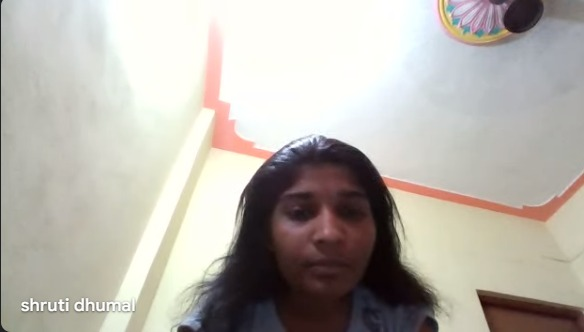

C:\Users\HP\AppData\Local\Temp\ipykernel_14644\3032900986.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)


1/1 [==============================] - 0s 58ms/step
Gender Predictions by Individual Models:
ResNet50 Model Prediction: female
InceptionV3 Model Prediction: female
CNN Model Prediction: female

Gender Prediction by Ensemble Model:
Ensemble Model Prediction: female
1/1 [==============================] - 0s 59ms/step
Model 1 predicted age: 10-15
Model 2 predicted age: 21-27
Model 3 predicted age: 21-27
Ensembled age group: 21-27


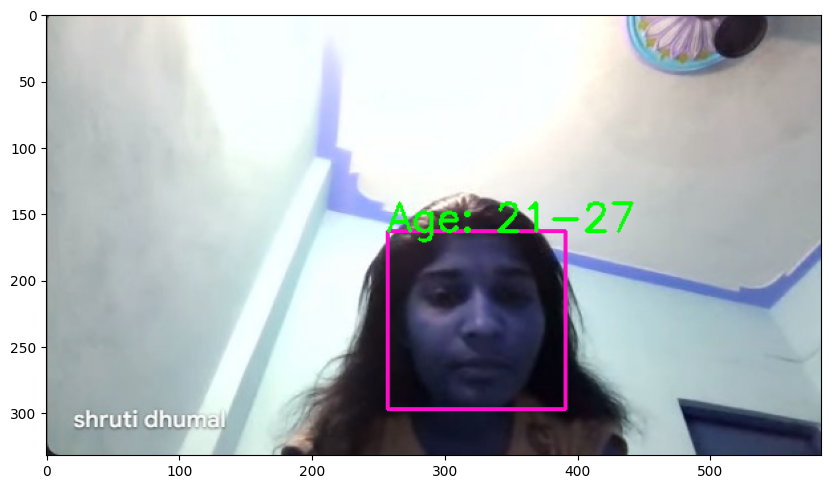

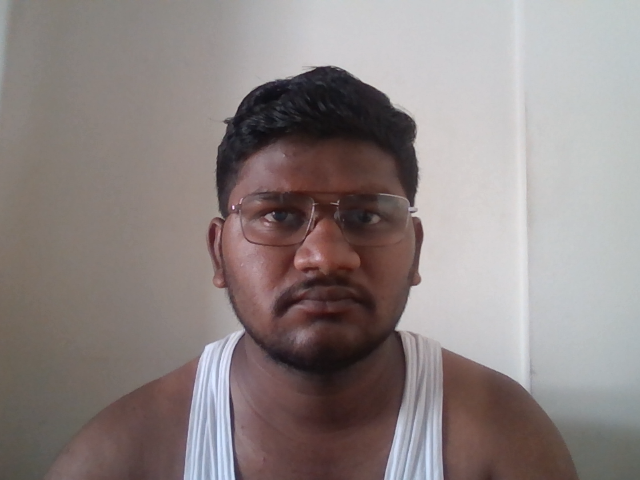

C:\Users\HP\AppData\Local\Temp\ipykernel_14644\3032900986.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)


1/1 [==============================] - 0s 55ms/step
Gender Predictions by Individual Models:
ResNet50 Model Prediction: male
InceptionV3 Model Prediction: male
CNN Model Prediction: female

Gender Prediction by Ensemble Model:
Ensemble Model Prediction: male
1/1 [==============================] - 0s 61ms/step
Model 1 predicted age: 15-20
Model 2 predicted age: 21-27
Model 3 predicted age: 3-6
Ensembled age group: 15-20


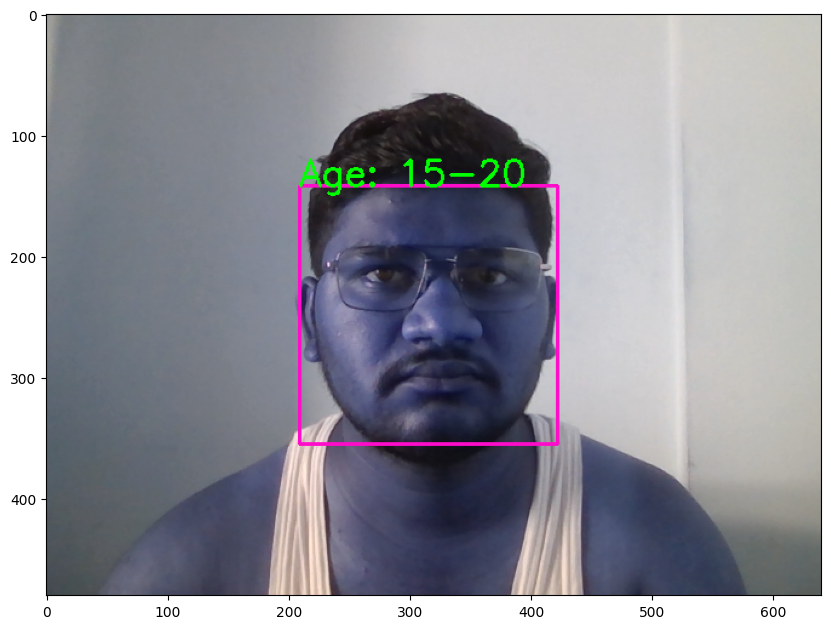

In [32]:
# Image upload and prediction functions
def on_upload_change(change):
    global uploaded_image
    uploaded_image = Image.open(BytesIO(change['new'][0]['content']))
    display.display(uploaded_image)

def on_predict_button_click(b):
    global uploaded_image
    if uploaded_image is not None:
        original_img, gray_img = predict_gender_from_image(uploaded_image)
        annotated_img = detect_faces_and_predict_age(original_img, gray_img)
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Please upload an image first.")

# Function to capture image from webcam
def capture_image_from_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print("Error: Could not read frame from webcam.")
        return
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return pil_img

def on_capture_button_click(b):
    global uploaded_image
    uploaded_image = capture_image_from_webcam()
    if uploaded_image is not None:
        display.display(uploaded_image)
        original_img, gray_img = predict_gender_from_image(uploaded_image)
        annotated_img = detect_faces_and_predict_age(original_img, gray_img)
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.show()

# Create widgets
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')
predict_button = widgets.Button(description="Predict")
predict_button.on_click(on_predict_button_click)
capture_button = widgets.Button(description="Capture from Webcam")
capture_button.on_click(on_capture_button_click)

# Display widgets
display.display(upload_widget)
display.display(predict_button)
display.display(capture_button)

# Variable to hold the uploaded image
uploaded_image = None